# Tutorial: using nonconformist (Conformal Prediction) with `Plot_utils`

# Table of content
* ## [1. Introduction](#intro)
 * ### [1.1 Prerequisites](#pre-req)
 * ### [1.2 Install `plot_utils`](#install)
* ## [2. Classification examples](#classification)
 * ### [2.1 Inductive Conformal Prediction](#icp)
 * ### [2.2 Transductive Conformal Prediction](#tcp)
* ## [3. Regression examples](#regression)
* ## [4. Customizations](#custom_layout)


## 1. Introduction <a id="intro"/>
    
**[Nonconformist](https://github.com/donlnz/nonconformist)** is i python library for conformal prediction, which out of the box plays well with [scikit-learn](https://scikit-learn.org/stable/) for easy extension of standard machine learning models into conformal predictors. Nonconformist also provides interfaces in order to create wrappers for other underlying models (not covered in this tutorial). Note that this tutorial builds on the examples available in the [nonconformist tutorial](https://github.com/donlnz/nonconformist/blob/master/README.ipynb), where more information can be found. One thing to note is that it is not actively maintained so it relies on some legacy stuff like using `np.random.uniform` instead of newer api's. 

**[Plot_utils](https://github.com/pharmbio/plot_utils)** is our own convenience library for calculating metrics and generating plots for conformal prediction. It is built on top of [matplotlib](https://matplotlib.org/) and it should thus be easy to customize according to your own preferences. Note that the plot_utils library will produce a different look in case you have [Seaborn](https://seaborn.pydata.org/) available on your python path as plot_utils will load that library, which in turn changes the defaults of matplotlib (see more under the section [Customization](#custom_layout)).

### 1.1 Prerequisites <a id="pre-req" />
- [Nonconformist](https://github.com/donlnz/nonconformist#user-installation) installed. Note that the version available from ''pip install'' has some bugs and requires an older version of scikit-learn, so installation with `git clone ..` is preferable!
- [plot_utils](https://github.com/pharmbio/plot_utils) available on your PYTHONPATH (not available through any package manager), use `git clone https://github.com/pharmbio/plot_utils.git` into your prefered location and use the steps below.

### 1.2 Install `plot_utils` (and optionally nonconformist) <a id="install" />

In [1]:
# Make sure to add the plot_utils code to your PYTHONPATH
import sys
sys.path.append('src')
# (optional) If you're using the "developer version" of nonconformist, add that to your PYTHONPATH as well
sys.path.append('../../nonconformist') # Replace with the correct location on your machine

In [2]:
# Import the required packages
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from nonconformist.cp import IcpClassifier, TcpClassifier,IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.model_selection import train_test_split

from pharmbio.cp import metrics
from pharmbio.cp import plotting # this import causes seaborn style be set if available on the path
import seaborn as sns


# Set the figure size to re-use so it fits the screen OK
fig_size = (14,7)
# Set a different context, default is "notebook" - so that all fonts are enlarged
sns.set_context("talk")

## 2. Classification examples <a id="classification" />
For classification problems there are two main divisions of conformal predictors, the _inductive_ and _transductive_. The _inductive_ ones relies on training the underlying classification model(s) once with a batch of training data (_proper training set_), and then calibrating the predictions on a separate _calibration set_. This approach is preferable in most real-life use cases as it is more computationally efficient compared to the _transductive_ apprach. The _inductive_ conformal predictors can further be subdivided to _inductive conformal predictor (ICP)_ and _aggregated conformal prediction (ACP)_ (or _split conformal predictor (SCP)_). The former relies on a single conformal predictor and enjoys mathematical proofs of producing well-calibrated predictions, whereas the latter relies on aggregating several individual ICPs, often increasing the predictive efficiency of the predictions, but simultaneously loosing the proofs of calibration. 

The _transductive_ approach on the other hand re-trains the underlying model once for every possible label of _every prediction_, i.e. for a three class problem every prediction requires fitting/training the underlying model _three times!_ Thus, this approach is only applicable to small data sets. The advantage of the transductive approach is that there is no longer any need to split up the available training data into _proper training set_ and _calibration set_, instead all training examples are used for both training and calibration.

In the following two subsections we will have a breif look at these two approaches and how to create plots.

### 2.1 Inductive Conformal Prediction (ICP) <a id="icp" />

Here we will use one of the toy data sets supplied in scikit-learn for quick examples. First we try out Inductive Conformal Prediction (ICP). Note here that you are required to split the training data into `proper training set` and `calibration set`, this should be performed randomly and in such a way that the calibration set is _large enough_ to support the _significance level_ you wish to use. 

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
print("Full size of iris data set:",iris.target.size,"records with labels:", iris.target_names)

Full size of iris data set: 150 records with labels: ['setosa' 'versicolor' 'virginica']


In [4]:
# Split into 50 test, remaining 100 for training the CP (proper train+calibration)
y_full_train_clf,y_test_clf, X_full_train_clf, X_test_clf = train_test_split(iris.target,iris.data, test_size=50)

# Split full training into 80 proper train and 20 calibration instances
y_train_clf, y_calib_clf, X_train_clf, X_calib_clf = train_test_split(y_full_train_clf, X_full_train_clf, train_size=80)

print("nProper:",len(y_train_clf),", nCalib:",len(y_calib_clf),", nTest:",len(y_test_clf))

nProper: 80 , nCalib: 20 , nTest: 50


In [5]:
# instantiate the CP model
clf = SVC(probability=True) # Create the underlying model, Support Vector Classifier model
nc = NcFactory.create_nc(clf) # Create a default nonconformity function
icp = IcpClassifier(nc, condition=lambda x: x[1]) # Create an ICP, the "condition" creates a mondrian ICP

# Train the ICP
icp.fit(X_train_clf, y_train_clf) # First train the underlying model
icp.calibrate(X_calib_clf,y_calib_clf) # Calibrate the ICP

# Predict the test set, this can be done in two ways;
np.random.seed(567)
predictions = icp.predict(X_test_clf, significance=.05) # i.e. 95% confidence - we get a matrix for the included classes

np.random.seed(567)
pvalues = icp.predict(X_test_clf) # Or no significance - get the raw p-values

print("\nPredicted classes:")
print(predictions[:5])
print("\nP-values:")
print(pvalues[:5])


Predicted classes:
[[False False  True]
 [ True False  True]
 [ True  True  True]
 [False False  True]
 [ True  True False]]

P-values:
[[0.03809771 0.03318498 0.14073452]
 [0.11912912 0.00350075 0.31501707]
 [0.74558859 0.05609493 0.16797213]
 [0.04297027 0.00612385 0.11717805]
 [0.12423572 0.7221879  0.01835587]]


OK, let us calculate some meaningful metrics out of this. One thing to note here is that `plot_utils` completely relies on p-values for all metrics and plotting functions, we never use the true/false outputs from giving a specific significance level. 

In [6]:
obs_fuzz = metrics.obs_fuzziness(y_test_clf,pvalues)
print("Observed fuzziness: %.3f" % obs_fuzz)

CM = metrics.confusion_matrix(y_test_clf, pvalues, sign=0.2, labels=iris.target_names)
print('Confusion matrix using significance \u03B5=0.2\n')
CM

Observed fuzziness: 0.145
Confusion matrix using significance ε=0.2



,setosa,versicolor,virginica
setosa,15,0,0
versicolor,0,11,0
virginica,0,0,14
Empty,3,4,3
Correct Multi-set,0,0,0
Incorrect Multi-set,0,0,0


Calculating the metrics is not the main purpose of `plot_utils` (as its name implies) but could potentially be useful for comparing the results across many models (e.g. by the Observed Fuzziness metric). Now let us go through the plots that can be generated.

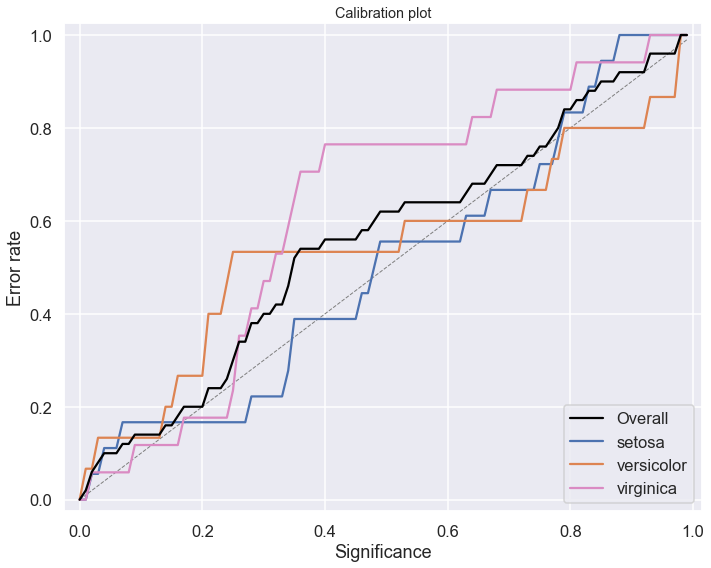

In [7]:
# Perhaps most important, the calibration plot:
calib_fig = plotting.plot_calibration_curve(y_test_clf, 
                                            pvalues, 
                                            title='Calibration plot',
                                            labels=iris.target_names,
                                            figsize=None)

The gray dashed line is the _expected_ error rate, i.e. the other curves should hopefully be close to this line, or at least display a smaller error rate than the specified significance level.

Here there are a few parameters we can play around with, e.g. instead display confidence vs accuracy by 'flipping' the x and y axis'. And we can specify which sigificance leves to include in the plot, e.g. if we are only interested in high-confidence levels we can specify that to `sign_vals`. 

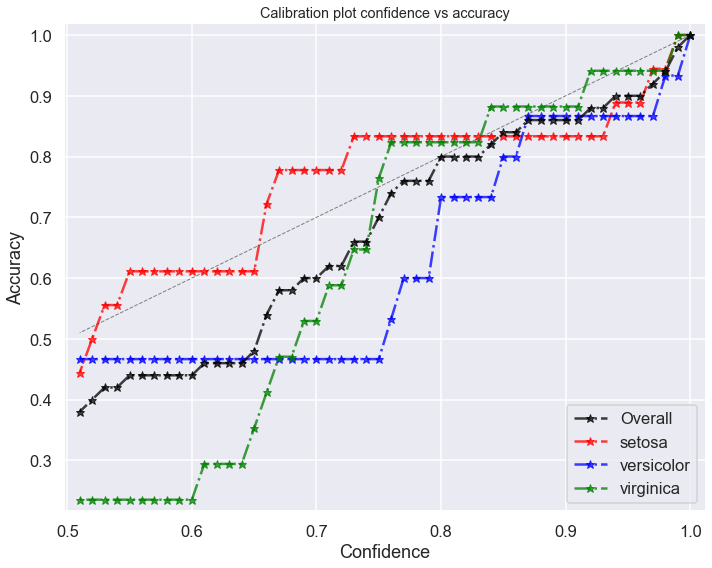

In [8]:
# Here we can customize the lines by passing matplotlib kw-arguments 
# These are passed on to the axes.plot(..) method
line_args = {'alpha': 0.75, 'marker':"*", 'linestyle': '-.', 'linewidth':2.5}

# Or if you prefer confidence vs accuracy:
conf_vs_acc_fig = plotting.plot_calibration_curve(y_test_clf, 
                                            pvalues, 
                                            title='Calibration plot confidence vs accuracy',
                                            labels=iris.target_names,
                                            sign_vals=np.arange(0.0,.5,0.01),
                                            cm = ['red','blue','green'],
                                            plot_all_labels=True, # If false - only plot 'overall accuracy'
                                            flip_x=True, # confidence instead of significance on x-axis
                                            flip_y=True, # accuracy instead of error rate on y-axis
                                            **line_args) # passed on to matplotlib 

After making sure that the calibration looks OK, we typically wish to investigate the _efficiency_ of the predictor. There are many ways of doing this, both independent of significance level (e.g. the OF criterion) or dependent on significance level (e.g. the average number of predicted classes). However, the metrics that do require a fixed significance level it's difficult to _a priori_ specify which significance to use. Perhaps in some settings you may have some external requirements, but it is still recommended to check multiple significance levels. This can be achieved using the "label distribution plot" in `plot_utils`.

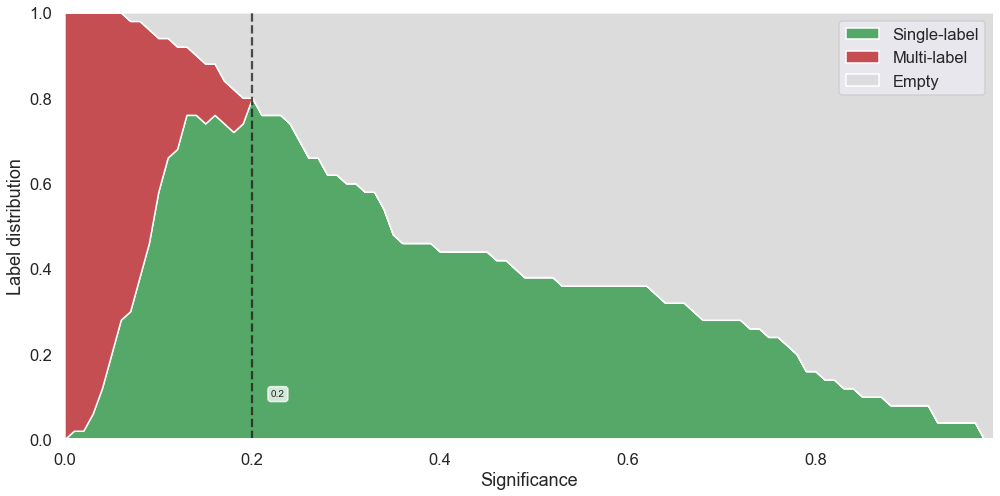

In [9]:
label_distr_fig = plotting.plot_label_distribution(y_test_clf,
                                                   pvalues,
                                                   sign_vals=np.arange(0,1,0.01),
                                                   mark_best=True,
                                                   display_incorrects=False,
                                                   figsize = fig_size)

From this plot it is easy to find a good significance level or possibly deem a model too bad to be useful. Comparing the results of a few models can be done with these plots, but evaluating tens of models may be too much. At least these figures can help to fix the significance level to use in that evaluation. Once having a significance level you can render confusion matrices and computing the average number of class labels or other metrics that are meaningful.

Here we show how to render the Confusion matrix that we computed above as a figure instead of a Pandas DataFrame object. This can be done using both the "bubble plot" (requires having Seaborn available) or a standard heatmap.

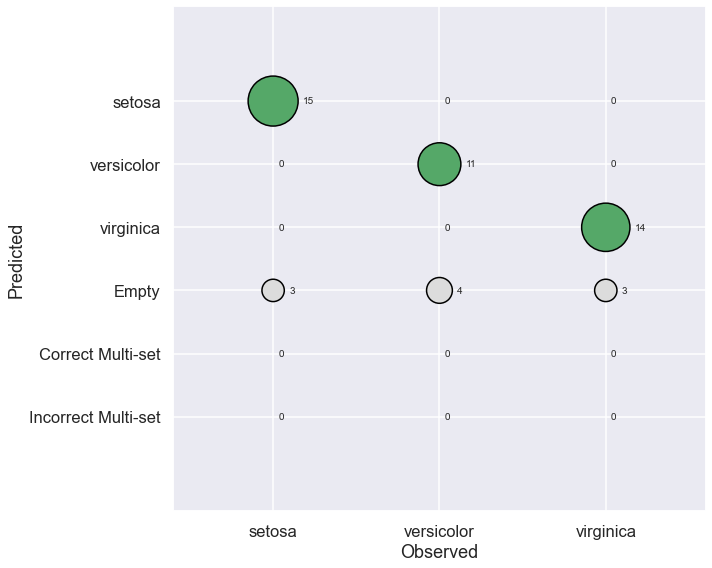

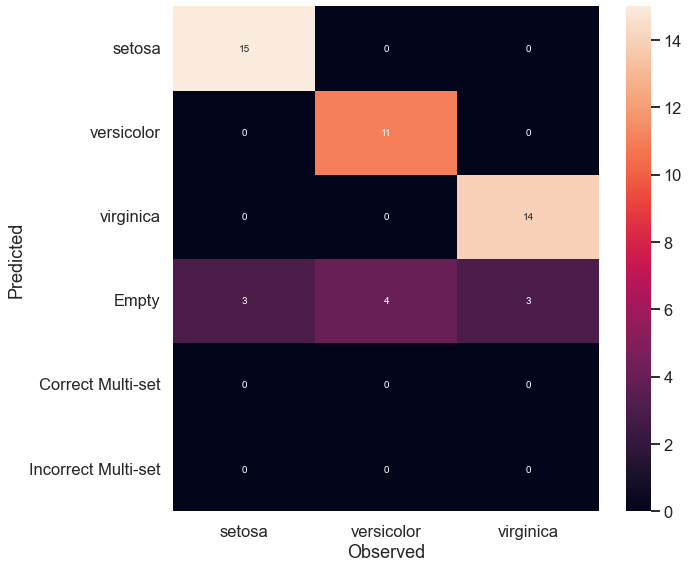

In [10]:
# Plot the confusion matrix with bubbles - requries seaborn!
CM_plot = plotting.plot_confusion_matrix_bubbles(CM,
                                                annotate=True) # If numbers should be printed next to bubbles

heatmap_fig = plotting.plot_confusion_matrix_heatmap(CM)

Notice that the heatmap is _not_ normalized in this case, which may be counterintuitive when rendering this as a heatmap if the classes are inbalanced. Lets instead compute a normalized confusion matrix and render that as a heatmap. Here we also show how to change the color map from the default.

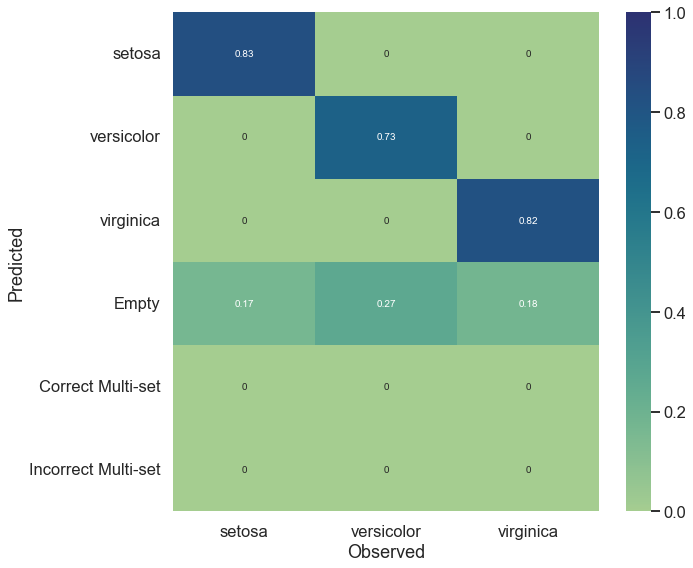

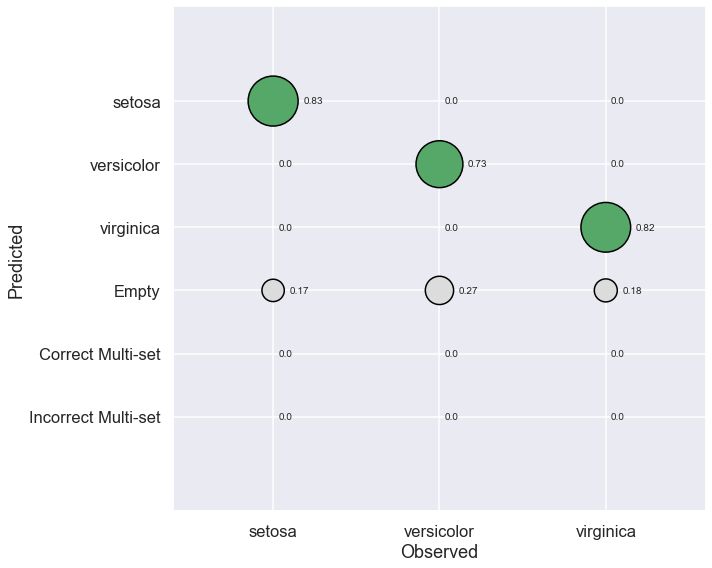

In [11]:
CM_norm = metrics.confusion_matrix(y_test_clf, 
                                   pvalues, 
                                   sign=0.2, 
                                   labels=iris.target_names, 
                                   normalize_per_class=True)

heatmap_normalized_fig = plotting.plot_confusion_matrix_heatmap(CM_norm,
                                                                cmap=sns.color_palette("crest", as_cmap=True),
                                                                vmin=0, vmax=1)

bubbles_normalized_plot = plotting.plot_confusion_matrix_bubbles(CM_norm,
                                                                 annotate=True)

### 3.1 Transductive Conformal Predictor (TCP) <a id="tcp" />
A downside of the ICP predictor is that we are required to split the full training data set into `proper training` (fitting the underlying model) and `calibration set` (calibrating the predictions). One way to alivate this is by training multiple ICPs and aggregating their predictions, commonly called Aggregated Conformal Predictor (ACP) or the more recent name Split Conformal Predictor (SCP). This aggregation, however, loses the guarantee in calibration that the single ICP enjoys. Here we take a look at the Transductive Conformal Predictor (TCP) which is computationally much more demanding but can produce better results when dealing with small data sets where it is possible to use TCP. The TCP use the full training set for both training the underlying model and calibrating the predictions.

In [12]:
clf = SVC(probability=True)
tcp_nc = NcFactory.create_nc(clf) # Create a default nonconformity function
tcp = TcpClassifier(nc, condition=lambda x: x[1])

# training now takes the full training set (no separate tcp.calibrate call needed)
tcp.fit(X_full_train_clf,y_full_train_clf)

# predict
pvalues_tcp = tcp.predict(X_test_clf)

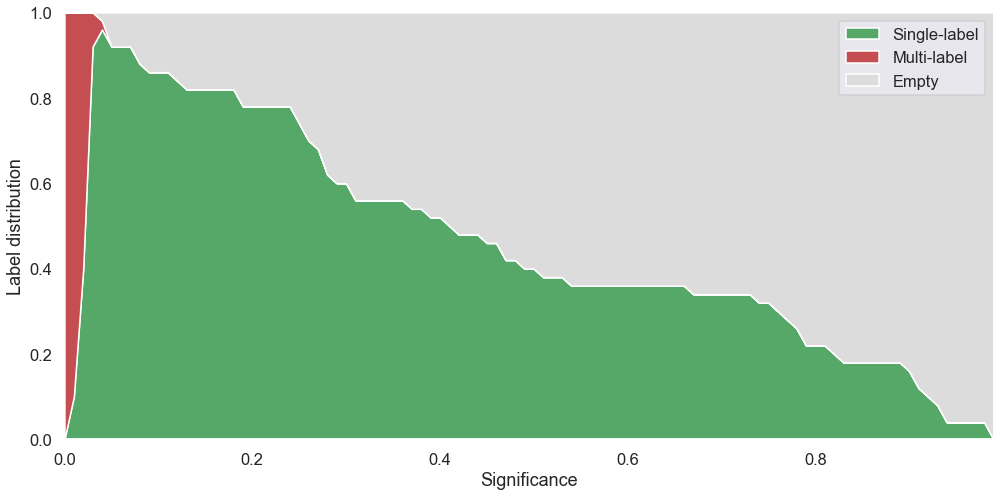

In [13]:
# Comparing the results from ICP and TCP can now be performed using e.g. the label distribution plot
label_distr_tcp_fig = plotting.plot_label_distribution(y_test_clf,
                                                       pvalues_tcp,
                                                       sign_vals=np.arange(0,1,0.01),
                                                       mark_best=False,
                                                       display_incorrects=False,
                                                       figsize=fig_size)
#label_distr_tcp_fig.axes[0].legend(fontsize=14); pass

Comparing this plot with the one from ICP above shows that TCP is *much* more efficient, both generating a higher proportion of single label predictions and at a much lower significance level.

## 4. Regression examples <a id="regression" />
For regression problems there is no _transductive_ approach available, instead we rely on either the single ICP or an aggregation of serveral ICPs (ACP/SCP). Further note that for regression problems we are always required to specify the significance levels, we cannot produce p-values and later apply/test different significance levels.

In [14]:
# Load data set
from sklearn.datasets import load_diabetes, make_regression
from nonconformist.acp import AggregatedCp, RandomSubSampler

X_gen, y_gen = make_regression(n_samples=200,n_features=20,n_informative=10, noise=10)
print("Generated data set having",len(X_gen), "records with", X_gen.shape[1], "features")

Generated data set having 200 records with 20 features


Again, being an _inductive_ approach we need to split up the data set ourselves. First we evaluate the single ICP and later we try the inclusion of more ICPs into an aggregation of models.

In [15]:
X_full_train,X_test, y_full_train, y_test = train_test_split(X_gen, y_gen,test_size=.3)

# Split full training into 80% proper train and 20% calibration instances
y_train, y_calib, X_train, X_calib = train_test_split(y_full_train, X_full_train, train_size=.8)
print("nProper:",len(y_train),", nCalib:",len(y_calib),", nTest:",len(y_test))

nProper: 112 , nCalib: 28 , nTest: 60


In [16]:
# Here we fix a significance level to use 
significance_lvl = 0.05
regressor = LinearRegression() # Create the underlying model
nc_reg = NcFactory.create_nc(regressor) # Create a default nonconformity function
icp_reg = IcpRegressor(nc_reg)

# Train underlying model and set calibration examples
icp_reg.fit(X_train,y_train)
icp_reg.calibrate(X_calib,y_calib)

# Predict
pred_intervals = icp_reg.predict(X_test, significance=significance_lvl)

First we can calculate some metrics without producing plots

In [17]:
print("range of observed labels: [%.2f ... %.2f]" % (np.min(y_test),np.max(y_test)))

print("median prediction interval width:",metrics.pred_width(pred_intervals))
print(f"error rate at significance %.2f: %.3f" % (significance_lvl, metrics.frac_error_reg(y_test,pred_intervals)))

range of observed labels: [-464.35 ... 403.14]
median prediction interval width: 55.46049706116162
error rate at significance 0.05: 0.000


Again, looking at raw numbers at a single significance level might be difficult, instead we look at several significance levels and plot the results. When not supplying any significance level, nonconformist will calculate predictions for all significance levels in the order; 0.01, 0.02,..,0.99 (99 tested levels). The output is given as ndarray of shape ("num predicted examples",2, "number of significance levels"). Where the 2 in the middle is the lower and upper points of the predicted intervals.

In [18]:
sign_vals = np.arange(0.01,1,0.01) # This is what nonconformist returns
many_intervals = icp_reg.predict(X_test)
many_intervals.shape

(60, 2, 99)

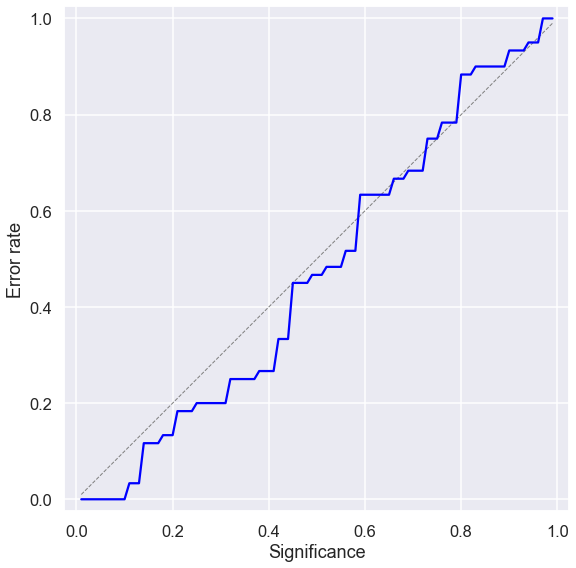

In [19]:
icp_calib_fig = plotting.plot_calibration_curve_reg(metrics.frac_error_reg(y_test,many_intervals),
                                                    sign_vals)

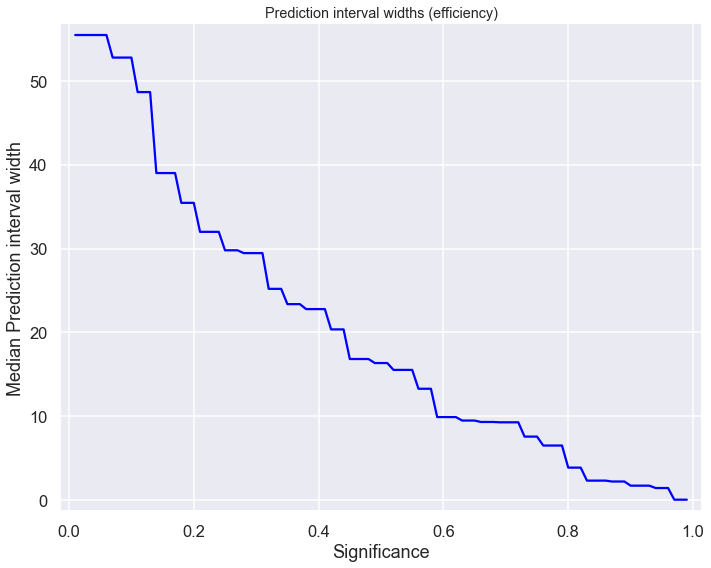

In [20]:
icp_eff_fig = plotting.plot_pred_widths(metrics.pred_width(many_intervals),
                                        sign_vals=sign_vals,
                                        title="Prediction interval widths (efficiency)")

This is a toy example, but from this plot you can probably decide a decent significance level in order to get "informative" predictions (i.e. having tight enough intervals). Any requirements on significance or the width of intervals will be problem-specific, here we will not focus on this but instead show the plotting utilities. Once having a sigificance level of interest you can plot the intervals and the corresponding true labels using the `plot_pred_intervals` function.

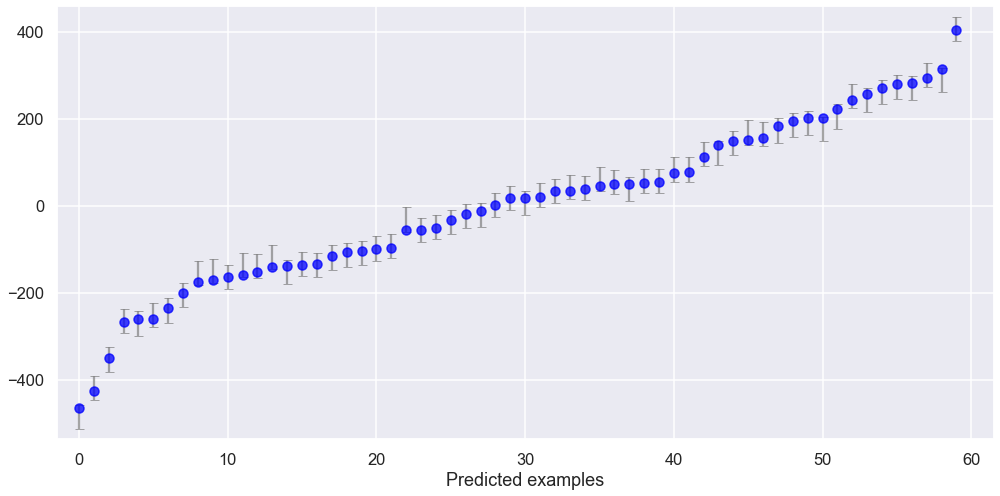

In [21]:
intervals_fig = plotting.plot_pred_intervals(y_test,
                                             many_intervals[:,:,np.where(sign_vals==significance_lvl)[0]].squeeze(),
                                             figsize = fig_size)

These predictions looks pretty good, the intervals seems tight enough to give relevant information at this fairly high confidence level of 95%. But, one thing to note is that every interval has the _same width_, instead of having smaller intervals for easier examples and wider for more difficult ones. In the terminology of nonconformist, the predictions are not "normalized". Let us try to normalize the predictions, here using an kNN regression model to estimate difficulty. 

In [22]:
icp_norm = IcpRegressor(NcFactory.create_nc(LinearRegression(),
                                            normalizer_model=KNeighborsRegressor(n_neighbors=11)))
icp_norm.fit(X_train,y_train)
icp_norm.calibrate(X_calib,y_calib)

many_norm_intervals = icp_norm.predict(X_test)
norm_intervals_005 = icp_norm.predict(X_test,significance_lvl)

print("median prediction interval width: %.2f" % metrics.pred_width(norm_intervals_005))
print("error rate at significance %.2f: %.3f" % (significance_lvl, metrics.frac_error_reg(y_test,norm_intervals_005)))

median prediction interval width: 70.57
error rate at significance 0.05: 0.017


In my example these gave larger median prediction widths than the non-normalized ICP predictions above (for the given significance level!), but still seems small enough to be informative. Let us plot the interval widths for both the non-normalized and normalized at the same time to investigate further! We can also plot the true labels and the prediction intervals as above.

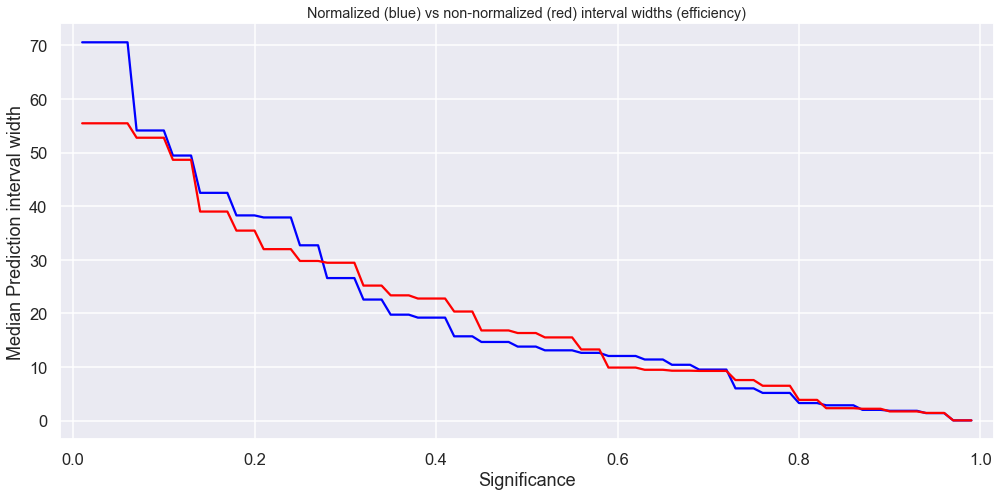

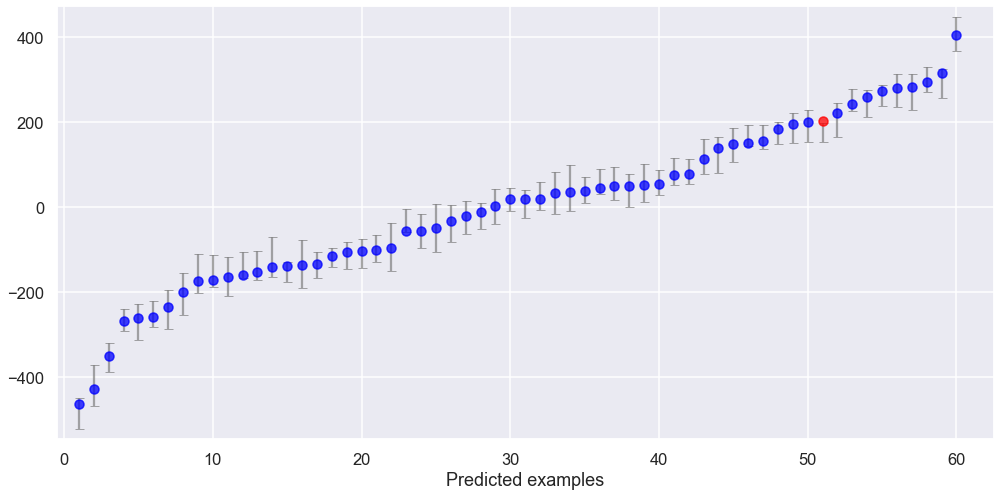

In [23]:
# plot the normalized in BLUE
norm_eff_fig = plotting.plot_pred_widths(metrics.pred_width(many_norm_intervals),
                                        sign_vals=sign_vals,
                                        title="Normalized (blue) vs non-normalized (red) interval widths (efficiency)",
                                        figsize=fig_size)
# pointer to the axes in above figure
ax = norm_eff_fig.axes[0] 
# plot non-normalized in RED 
plotting.plot_pred_widths(metrics.pred_width(many_intervals),
                          sign_vals=sign_vals,
                          color='red',
                          ax=ax) # specify the same axes to plot in
# Make sure all lines are shown
ax.autoscale(axis='y')

norm_intervals_fig = plotting.plot_pred_intervals(y_test,
                                                  many_norm_intervals[:,:,np.where(sign_vals==significance_lvl)[0]].squeeze(),
                                                  figsize=fig_size,
                                                  x_start_index = 1
                                               )


Well that looks much better, although the mean of the intervals do not seem to follow the observations that much. Perhaps using some other underlying model might improve the results greatly, but this is only a toy example. Now let us try out if the aggregated/split conformal predictor can improve the results!

median prediction interval width (ACP): 55.54259500739869
error rate at significance 0.05: 0.017


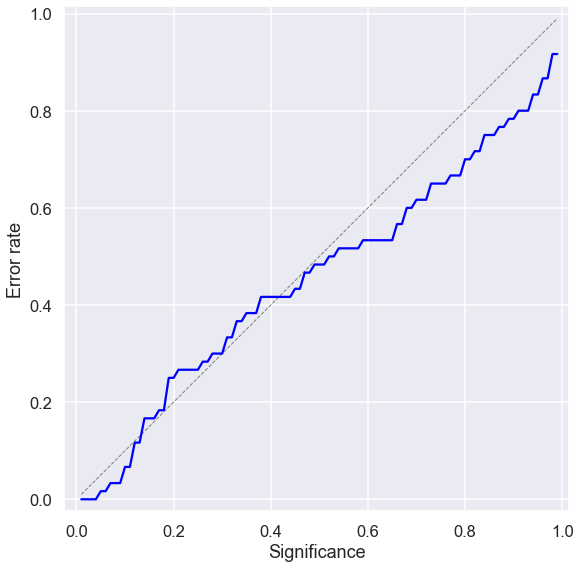

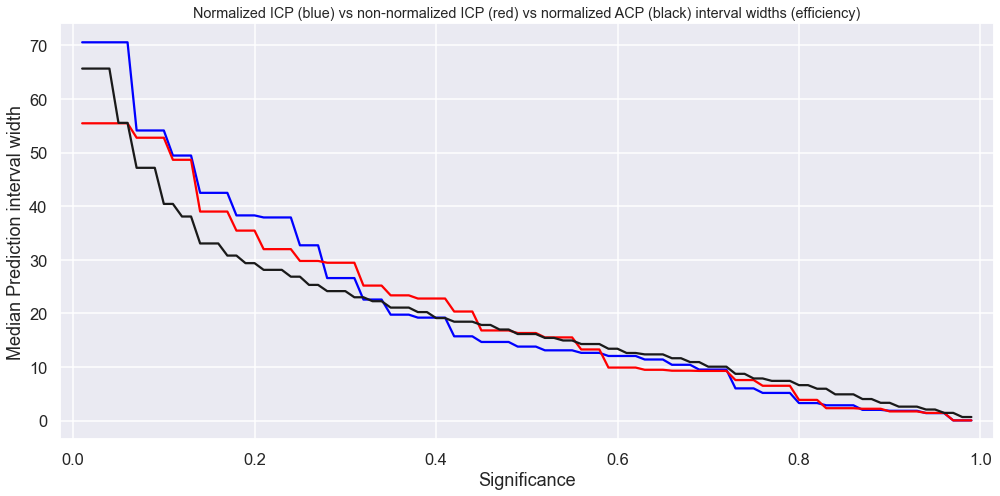

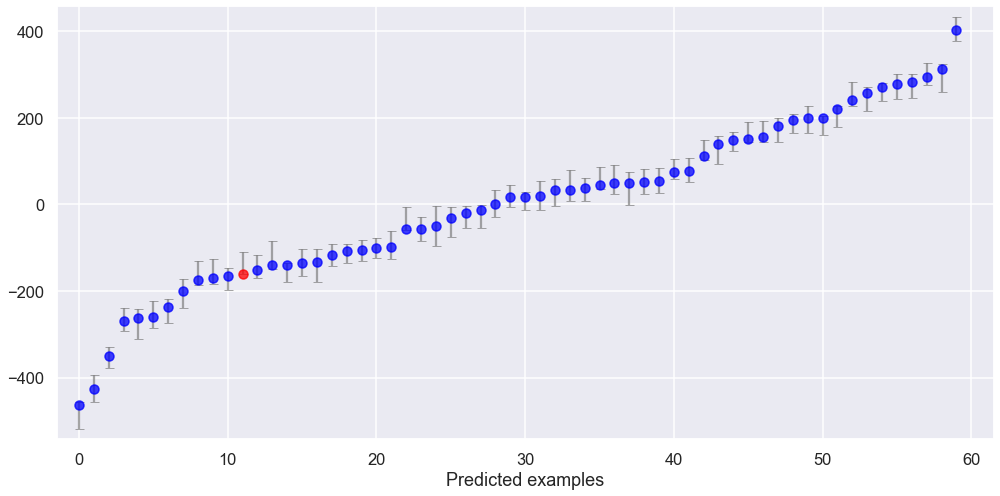

In [24]:
# Create an aggregated conformal predictor with 10 "sub-models"
# We can re-use the icp_norm that we created before, to get the normalized ICP as the basis
acp_reg = AggregatedCp(icp_norm, 
                       sampler = RandomSubSampler(), 
                       aggregation_func = lambda x: np.median(x, axis=2), # More common to use _median_ than mean (which is default)
                       n_models=10)

# Train and "calibrate" at the same time
acp_reg.fit(X_full_train,y_full_train)

acp_intervals_005 = acp_reg.predict(X_test,significance=significance_lvl)
acp_intervals = acp_reg.predict(X_test)


print("median prediction interval width (ACP):",metrics.pred_width(acp_intervals_005))
print(f"error rate at significance %.2f: %.3f" % (significance_lvl, metrics.frac_error_reg(y_test,acp_intervals_005)))

acp_calib_fig = plotting.plot_calibration_curve_reg(metrics.frac_error_reg(y_test,acp_intervals),sign_vals)

# Plot ICP, ICP_normalized, ACP_normalized in the same plot
# plot the normalized in BLUE
acp_eff_fig = plotting.plot_pred_widths(metrics.pred_width(many_norm_intervals),
                                        sign_vals=sign_vals,
                                        title="Normalized ICP (blue) vs non-normalized ICP (red) vs normalized ACP (black) interval widths (efficiency)",
                                        figsize=fig_size)
# pointer to the axes in above figure
ax = acp_eff_fig.axes[0] 
# plot non-normalized ICP in RED 
plotting.plot_pred_widths(metrics.pred_width(many_intervals),
                          sign_vals=sign_vals,
                          color='red',
                          ax=ax) # specify the same axes to plot in
# plot ACP in black
plotting.plot_pred_widths(metrics.pred_width(acp_intervals),
                          sign_vals=sign_vals,
                          color='k',
                          ax=ax) # specify the same axes to plot in

# Make sure all lines are shown
ax.autoscale(axis='y')


acp_norm_intervals_fig = plotting.plot_pred_intervals(y_test,acp_intervals[:,:,np.where(sign_vals==significance_lvl)[0]].squeeze(),
                                                      figsize = fig_size)

In the `plot_pred_intervals` function there are a lot of parameters to tweak in case you wish to have a different apperance, here's how to change into black and white sort of theme, with different marker style for the incorrectly predicted.

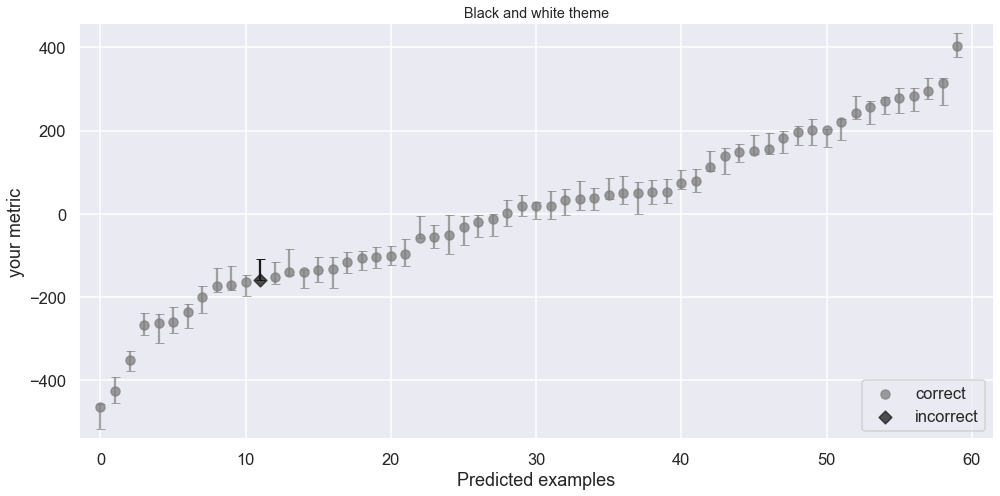

In [25]:
bw_fig = plotting.plot_pred_intervals(y_test,
                                      acp_intervals[:,:,np.where(sign_vals==significance_lvl)[0]].squeeze(),
                                      correct_color='gray',
                                      correct_label='correct',
                                      
                                      incorrect_color = 'k',
                                      incorrect_marker='D',
                                      incorrect_ci='k',
                                      incorrect_ci_alpha=1,
                                      incorrect_label='incorrect',
                                      
                                      figsize = fig_size,
                                      y_label='your metric',
                                      title='Black and white theme')

bw_fig.axes[0].legend(loc='lower right'); pass

## 4. Customization <a id="custom_layout" />
Matplotlib is very customizable, here we show one way of changing the layout by using available styles from [Seaborn](http://seaborn.pydata.org/tutorial/aesthetics.html). 

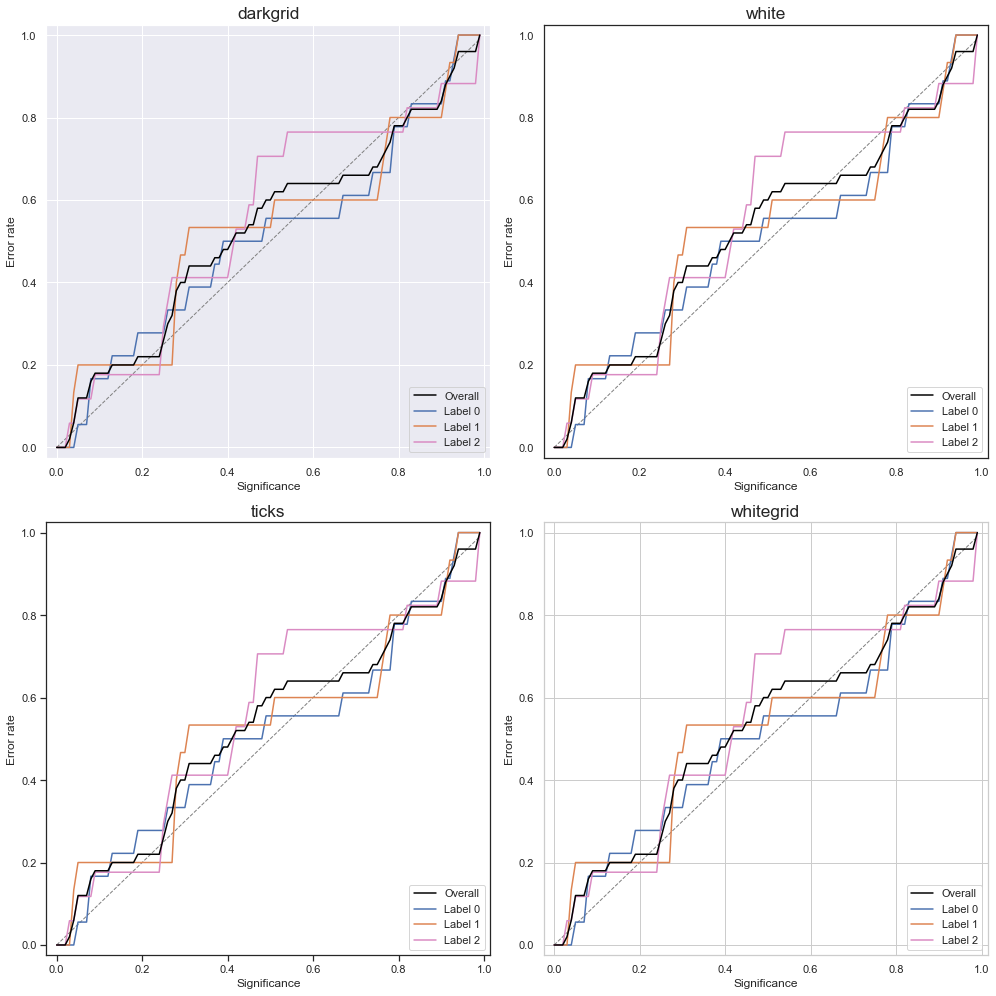

In [26]:
import matplotlib.pyplot as plt

# Change context (e.g. different default font-size for labels)
sns.set_context("notebook") # "poster", "paper"


def make_plot(ax, title):
    plotting.plot_calibration_curve(y_test_clf, pvalues_tcp, ax=ax,title=title)


f = plt.figure(figsize=(14,14))
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    make_plot(ax,"darkgrid")

with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 1])
    #sns.despine()
    make_plot(ax,"white")

with sns.axes_style("ticks"):
    ax = f.add_subplot(gs[1, 0])
    make_plot(ax,"ticks")

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 1])
    make_plot(ax,"whitegrid")